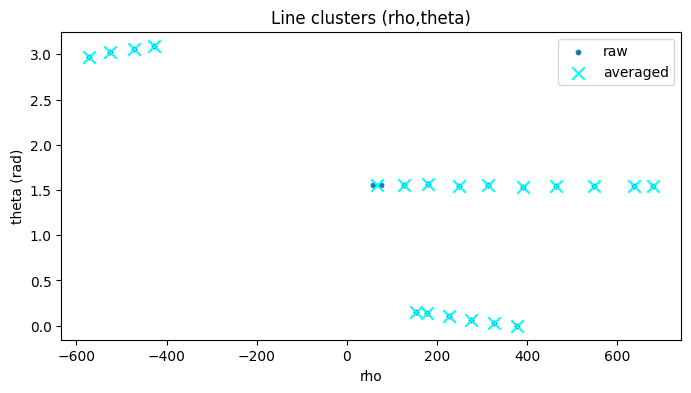

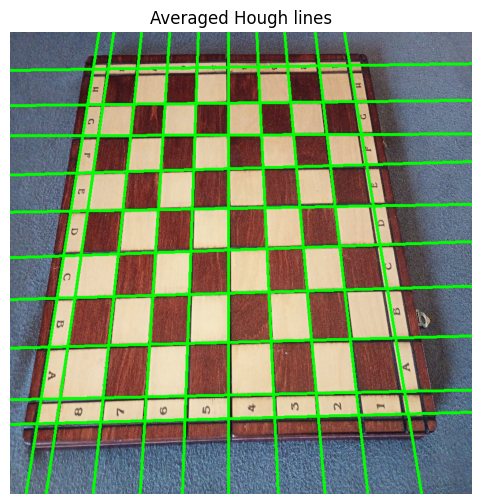

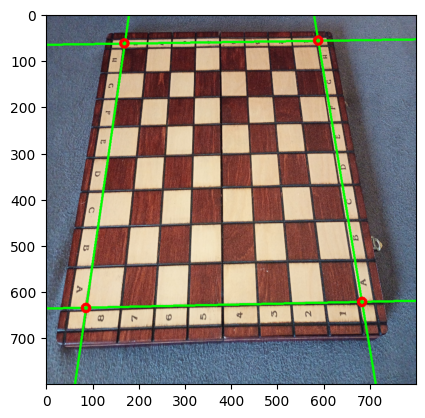

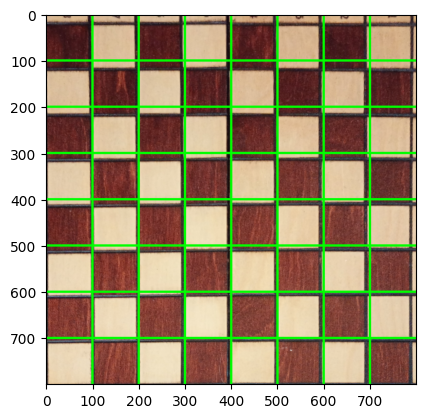

In [362]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import itertools
import math


def cannyHough(img, show_output=False):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    blur = cv2.bilateralFilter(blur, 13, 100, 100)

    edges = cv2.Canny(blur, 100 ,150)

    lines = cv2.HoughLines(edges, rho=1, theta=np.pi/180, threshold=100)

    lines_list = []
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            lines_list.append((float(rho), float(theta)))

    if not show_output:
        return lines_list
    
    fig, ax = plt.subplots(1, 2, figsize=(10,5))

    img_copy = img.copy()
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 2000 * (-b))
            y1 = int(y0 + 2000 * (a))
            x2 = int(x0 - 2000 * (-b))
            y2 = int(y0 - 2000 * (a))
            cv2.line(img_copy, (x1, y1), (x2, y2), (0, 255, 0), 3)
    ax[0].imshow(edges, 'gray')
    ax[0].axis('off')
    ax[1].imshow(img_copy)
    ax[1].axis('off')
    plt.show()

    return lines_list

def averageLines(lines, img, show_output=False):
    rho_tol = 20.0          # pixels
    theta_tol = np.deg2rad(30.0)  # radians

    if lines is None:
        return
    
    clusters = []
    for line in lines:
        rho, theta = line
        placed = False
        for cl in clusters:
            r_avg, t_avg, cnt = cl
            dtheta = abs(theta - t_avg)
            dtheta = min(dtheta, 2*np.pi - dtheta)
            if abs(rho - r_avg) < rho_tol and dtheta < theta_tol:
                new_cnt = cnt + 1
                cl[0] = (r_avg*cnt + rho) / new_cnt

                x = np.cos(t_avg)*cnt + np.cos(theta)
                y = np.sin(t_avg)*cnt + np.sin(theta)
                cl[1] = np.arctan2(y, x)
                cl[2] = new_cnt
                placed = True
                break

        if not placed:
            clusters.append([rho, theta, 1])

    avg_lines = [(cl[0], cl[1]) for cl in clusters]

    if not show_output:
        return avg_lines

    # Draw averaged lines on a copy
    vis_avg = img.copy()
    for rho, theta in avg_lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(vis_avg, (x1, y1), (x2, y2), (0, 255, 0), 3)

    # Show original detected rho/theta and averaged ones
    

    plt.figure(figsize=(8,4))
    if len(lines)>0:
        rs, ts = zip(*lines)
        plt.scatter(rs, ts, s=10, label='raw')
    if len(avg_lines)>0:
        ars, ats = zip(*avg_lines)
        plt.scatter(ars, ats, c='cyan', s=80, marker='x', label='averaged')
    plt.xlabel('rho'); plt.ylabel('theta (rad)'); plt.legend(); plt.title('Line clusters (rho,theta)')
    plt.show()

    plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(vis_avg, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.title('Averaged Hough lines'); plt.show()

    return avg_lines

def show_lines(img, lines):
    vis = img.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 2000 * (-b))
        y1 = int(y0 + 2000 * (a))
        x2 = int(x0 - 2000 * (-b))
        y2 = int(y0 - 2000 * (a))
        cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), 3)
    plt.imshow(vis)
    plt.show()

def angle_diff(a, b):
    """Return minimal absolute difference between two angles in radians."""
    d = np.abs(a - b) % np.pi
    return min(d, np.pi - d)

def intersections_from_rho_theta(rhos, thetas, deg=False, eps=1e-9):
    """
    rhos: iterable of length N (here N=4)
    thetas: iterable of length N (same units)
    deg: if True, input thetas are in degrees (converted to radians)
    eps: threshold to consider two lines parallel (|denom| < eps)
    Returns: list of dicts: [{'pair': (i,j), 'x': x, 'y': y, 'parallel': bool}, ...]
    """
    box_max = 800
    box_min = 0
    rhos = np.asarray(rhos, dtype=float)
    thetas = np.asarray(thetas, dtype=float)
    if deg:
        thetas = np.deg2rad(thetas)

    results = []
    N = len(rhos)
    for i,j in itertools.combinations(range(N), 2):
        rho1, th1 = rhos[i], thetas[i]
        rho2, th2 = rhos[j], thetas[j]
        denom = math.sin(th2 - th1)  # sin(theta2-theta1)
        x = (rho1 * math.sin(th2) - rho2 * math.sin(th1)) / denom
        y = (-rho1 * math.cos(th2) + rho2 * math.cos(th1)) / denom
        if box_min <= x <= box_max and box_min <= y <= box_max:
            results.append([x , y])
    return results

def x_intercept(line):
    rho, theta = line
    if np.cos(theta) != 0:
        return rho / np.cos(theta)  # x where y=0
    else:
        return float('inf')  # vertical line
    
def y_intercept(line):
    rho, theta = line
    if np.sin(theta) != 0:
        return rho / np.sin(theta)  # x where y=0
    else:
        return float('inf')  # vertical line

def order_points(pts):
    # pts: array of 4 points [[x1,y1],[x2,y2],...]
    rect = np.zeros((4, 2), dtype="float32")
    
    # sum of coordinates: top-left has smallest sum, bottom-right has largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[3] = pts[np.argmax(s)]  # bottom-right
    
    # difference of coordinates: top-right has smallest diff, bottom-left has largest diff
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[2] = pts[np.argmax(diff)]  # bottom-left
    
    return rect

def findChessboard(lines, img, show_optput=False):

    h_lines = []
    v_lines = []

    theta_tol = np.deg2rad(10.0)
    h_val = np.pi/2
    v_val = 0.0
    for line in lines:
        rho, theta = line
        h_diff = angle_diff(theta, h_val)
        v_diff = angle_diff(theta, v_val)
        if h_diff < theta_tol:
            h_lines.append([rho, theta])
        elif v_diff < theta_tol:
            v_lines.append([rho, theta])
    

    h_lines.sort(key=y_intercept)
    v_lines.sort(key=x_intercept)

    y_inter = [y_intercept(e) for e in h_lines]
    h_diffs = []
    for i in range(len(y_inter)-1):
        h_diffs.append(y_inter[i+1] - y_inter[i])
    h_median = np.median(h_diffs)
    
    for i in range(len(h_diffs)):
        if h_diffs[i] > h_median - 10:
            h_min = h_lines[i]
            break

    for i in range(len(h_diffs)):
        idx = len(h_diffs)-1-i
        if h_diffs[idx] > h_median - 10:
            h_max = h_lines[idx+1]
            break

    x_inter = [x_intercept(e) for e in v_lines]
    v_diffs = []
    for i in range(len(x_inter)-1):
        v_diffs.append(x_inter[i+1] - x_inter[i])
    v_median = np.median(v_diffs)

    for i in range(len(v_diffs)):
        if v_diffs[i] > v_median - 5:
            v_min = v_lines[i]
            break

    for i in range(len(v_diffs)):
        idx = len(v_diffs)-1-i
        if v_diffs[idx] > v_median - 5:
            v_max = v_lines[idx+1]
            break


    bounding_lines = [h_max, h_min, v_max, v_min]
    rhos = [e[0] for e in bounding_lines]
    thetas = [e[1] for e in bounding_lines]

    corners = intersections_from_rho_theta(rhos, thetas)
    if not show_optput:
        return corners


     # Draw averaged lines on a copy
    if show_optput:
        vis_corners = img.copy()
        for rho, theta in bounding_lines:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 2000 * (-b))
            y1 = int(y0 + 2000 * (a))
            x2 = int(x0 - 2000 * (-b))
            y2 = int(y0 - 2000 * (a))
            cv2.line(vis_corners, (x1, y1), (x2, y2), (0, 255, 0), 3)

        for x,y in corners:
            cv2.circle(vis_corners, (int(x), int(y)), 8, (0, 0, 255), 6)

        plt.imshow(cv2.cvtColor(vis_corners, cv2.COLOR_BGR2RGB))
        plt.show()
    return corners
    
def transform_image(img, corners, show_output=False):
    width, height = 800, 800
    corners = np.float32(corners)
    corners = order_points(corners)
    pts2 = np.float32([[0,0], [width, 0], [0, height], [width, height]])
    matrix = cv2.getPerspectiveTransform(corners, pts2)
    result = cv2.warpPerspective(img, matrix, (800, 800))
    if show_output:
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        plt.show()
    return result

def divide_chessboard(img, show_output=False):
    # Number of cells
    rows, cols = 8, 8
    cell_width = img.shape[1] // cols
    cell_height = img.shape[0] // rows

    # Draw vertical lines
    img_vis = img.copy()
    for i in range(1, cols):
        x = i * cell_width
        cv2.line(img_vis, (x, 0), (x, 800), (0,255, 0), 4)

    # Draw horizontal lines
    for i in range(1, rows):
        y = i * cell_height
        cv2.line(img_vis, (0, y), (800, y), (0,255, 0), 4)
    if show_output:
        plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
        plt.show()
    return cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)


img_color = cv2.imread("img/empty2.jpg", cv2.IMREAD_COLOR)
img_color = cv2.resize(img_color, (800, 800))
lines = cannyHough(img_color, False)
avg_lines = averageLines(lines, img_color, False)
avg_lines = averageLines(avg_lines, img_color, True)
corners = findChessboard(avg_lines, img_color, True)
img_trsf = transform_image(img_color, corners, False)
div = divide_chessboard(img_trsf, True)

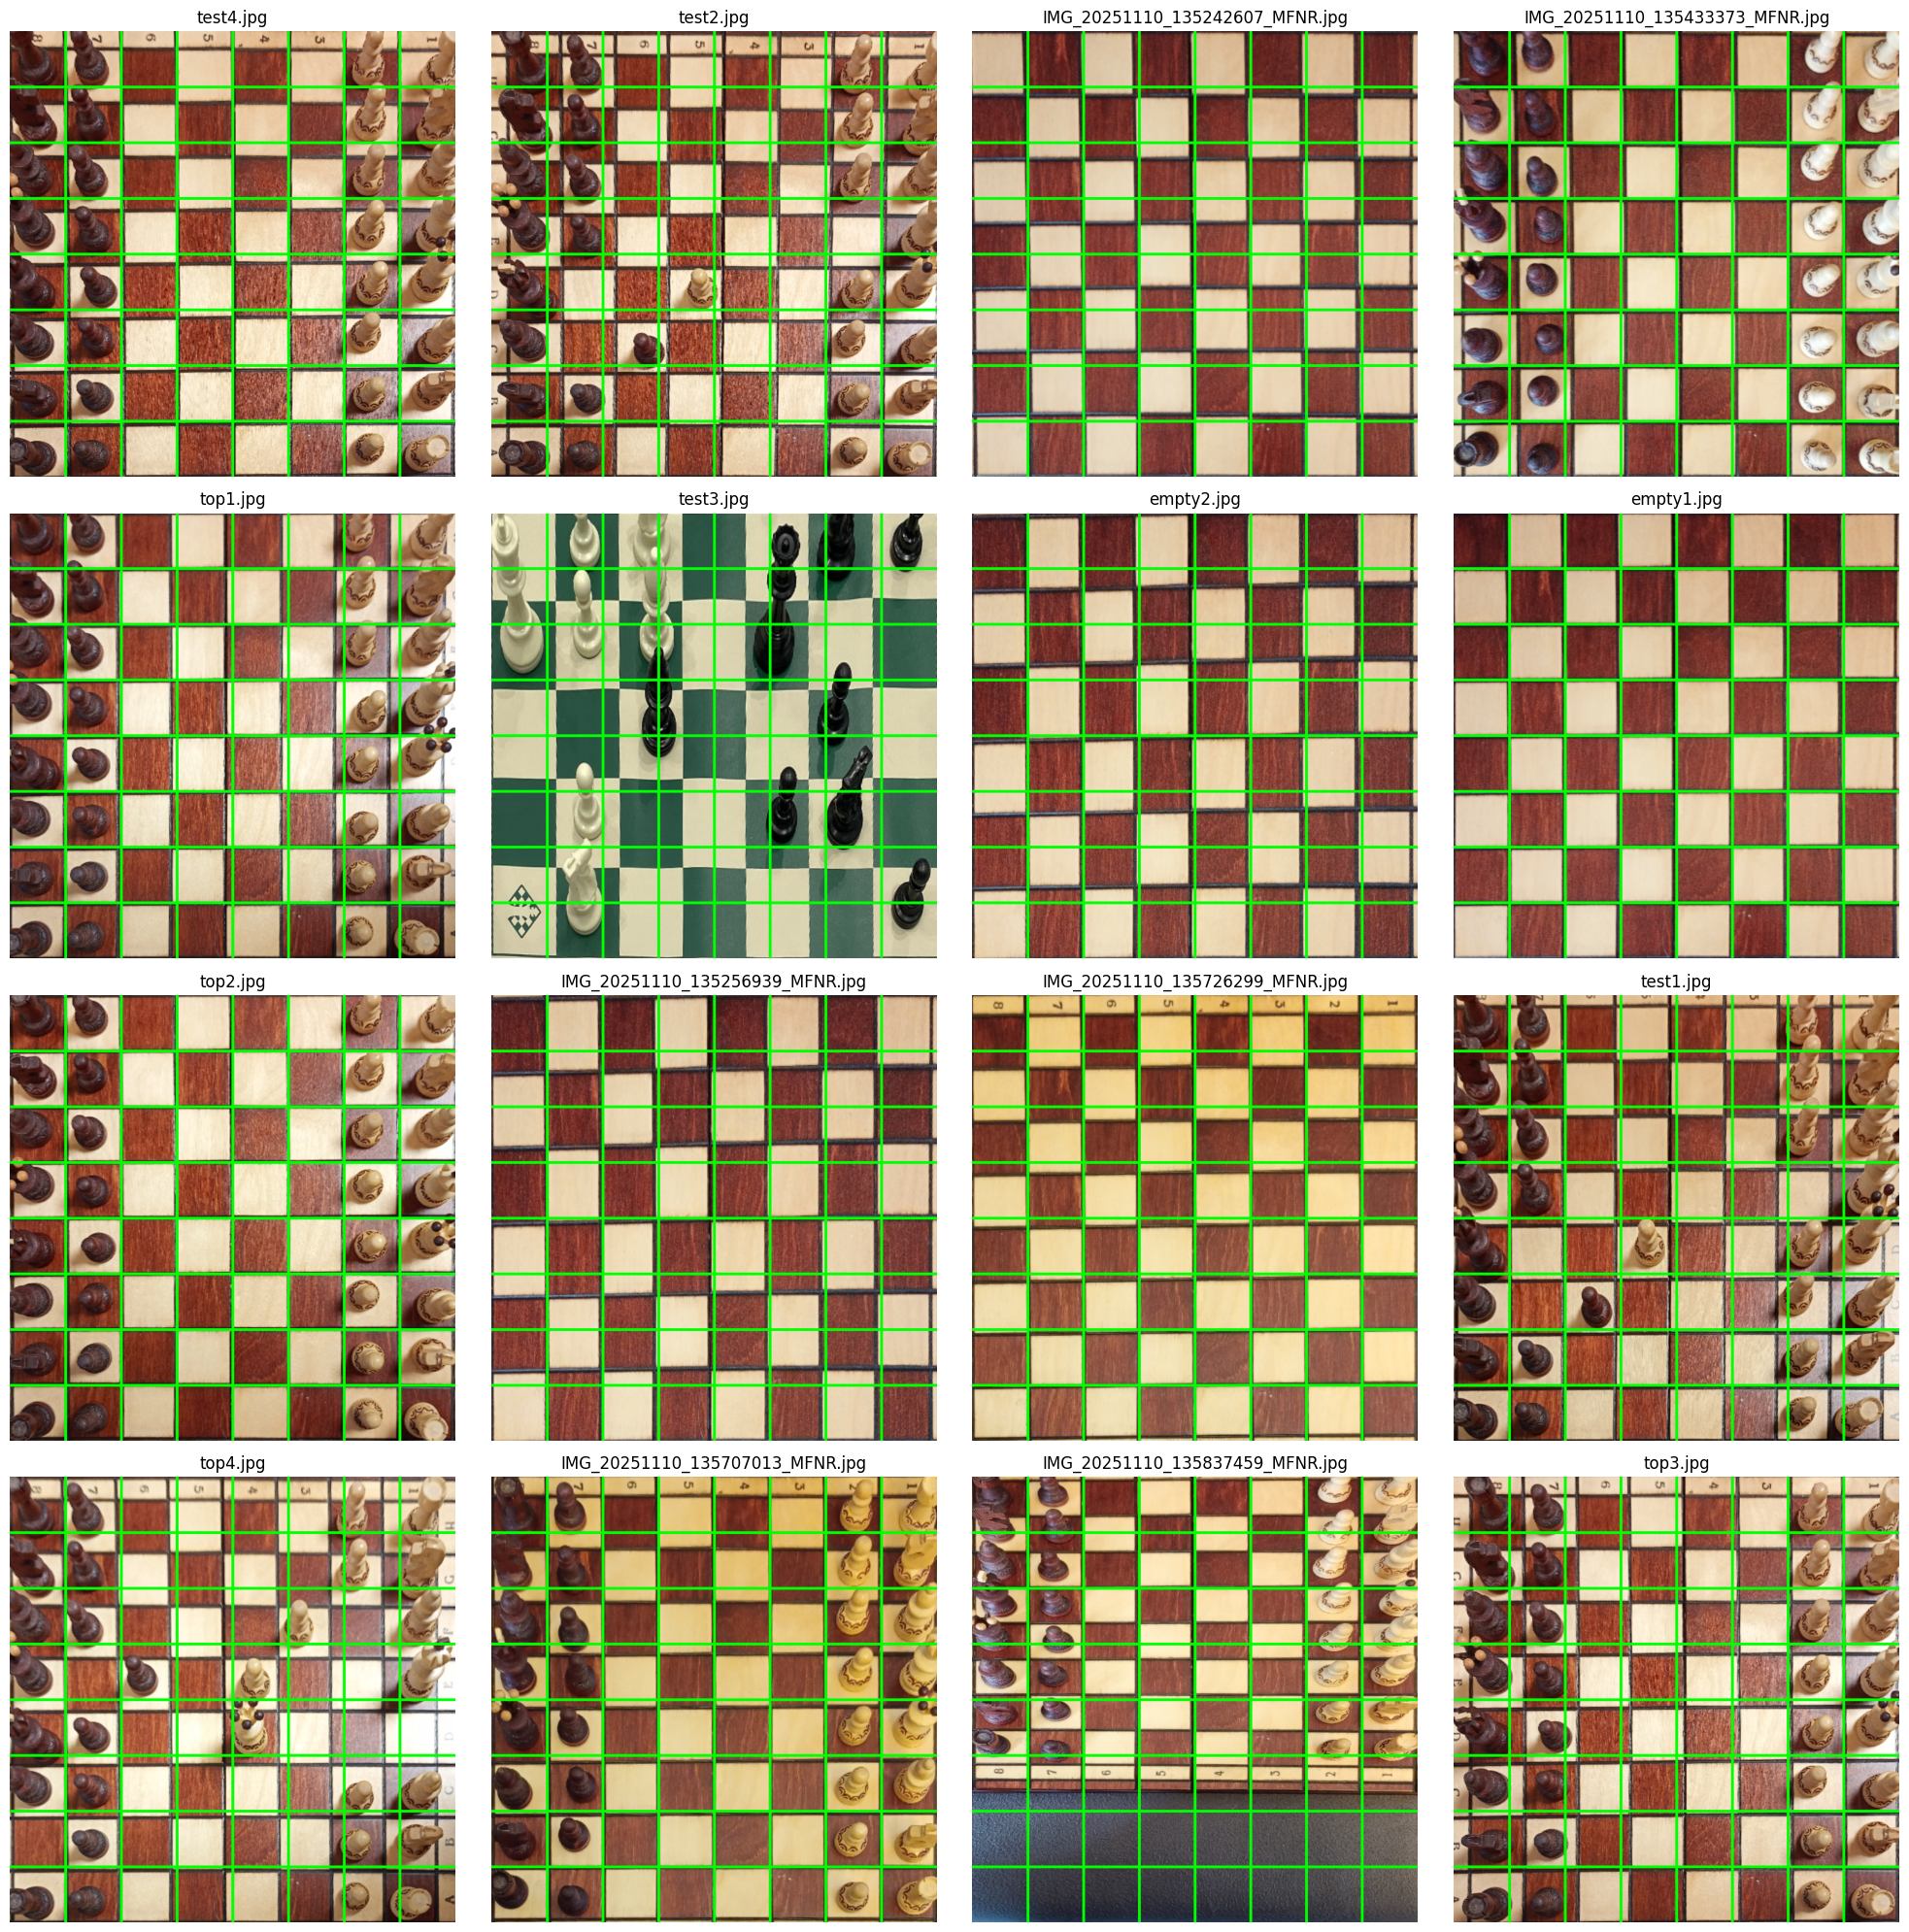

In [365]:
def fitChessboard(img_path):
    img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img_color = cv2.resize(img_color, (800, 800))
    lines = cannyHough(img_color, False)
    avg_lines = averageLines(lines, img_color, False)
    # avg_lines = averageLines(avg_lines, img_color, False)
    corners = findChessboard(avg_lines, img_color, False)
    img_trsf = transform_image(img_color, corners, False)
    div = divide_chessboard(img_trsf, False)
    return div

import os

directory = "/home/igorsiata/ur3_chess_player/vision_system/img"

fig, ax = plt.subplots(4,4, figsize=(20,20))

for idx, filename in enumerate(os.listdir(directory)):
    if idx > 15:
        break
    file_path = os.path.join(directory, filename)
    if os.path.isfile(file_path):
        res = fitChessboard(file_path)
        ax[idx//4, idx%4].imshow(res)
        ax[idx//4, idx%4].set_title(os.path.basename(filename))
        ax[idx//4, idx%4].axis('off')
plt.tight_layout()
plt.show()